## Домашняя работа №5

Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=Warning)

In [2]:
#!conda install xlrd

In [3]:
data = pd.read_excel("отзывы за лето.xls")
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [4]:
data['Rating'].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [5]:
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3
data['target'] = data['target'].astype(int)

In [6]:
data['target'].value_counts()

1    16724
0     3024
Name: target, dtype: int64

Положительные отзывы:

In [7]:
data.loc[data['target'] == 1, 'Content'].sample(20, random_state=42)

19216                                  Спасибо, все удобно
12380                                                   Ok
953                                                Отлично
15329                                     Удобное спасибо!
12421                                  Отличное приложение
17805                                                   Ок
8245                                                  норм
7299                                               отлично
5504                              Очень удобное приложение
19928                                              Отлично
12680    Заходить в приложение стало в 2 раза дольше,фу...
7209                Не могу скачать приложение, ошибка 963
12721                 Всё отлично!приложение очень радует!
10057                                Удобно.Быстро.Надежно
3191                                Очень просто и быстро.
5886     Мне понравилось очень удобно сидиш дома и все ...
10309    Перестало заходить, причем именно дома по wi f.

Отрицательные отзывы:

In [8]:
data.loc[data['target'] == 0, 'Content'].sample(20, random_state=42)

20636                     Дайте доступ к роот правам, с*ки
2226     По три раза просит пароль задолбал исправьте п...
13980    Ну задолбало уже по 2-3 раза вводить пароль дл...
13173    Если честно - дерьмо Ваше приложение! Исправьт...
8452                             Не приходит СМС с паролем
10162    В шаблонах чехарда появляются записи из Контак...
506      Куда подевалось вход по отпечатку? При запуске...
17032    Все было хорошо недавно перестало работать из....
11215    Не устанавливается приложение!Раньше все было ...
3582     Установил приложение. Зарегистрироваться так и...
20173    У меня тоже телефон meizu pro 6. И тоже пишет ...
9355     Почему у сбера переводы длятся вечность? Польз...
8580     Здравствуйте. После последнего обновления стал...
1742     При регистрации не могу ввести разовый пароль ...
456      Разрабы тупые рукожопы! Наковыряли в обновлени...
15358    Не могу войти на свой счет и зарегать новый не...
20115    Очень медленное приложение в начале загрузки, .

### Обработка текстов

In [9]:
#!pip install pymorphy2

In [10]:
import nltk
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer

In [11]:
#nltk.download('punkt')

In [12]:
punctuation = r'[,.]'
morpher = MorphAnalyzer()

stop = {'без', 'безо', 'близ', 'в', 'во', 'вместо', 'вне',
        'для', 'до', 'за', 'из', 'изо', 'из-за', 'из-под', 
        'к', 'ко', 'кроме', 'между', 'меж', 'на', 'над', 'надо',
        'о', 'об', 'обо', 'от', 'ото', 'перед', 'передо', 'пред', 'предо',
        'пo', 'под', 'подо', 'при', 'про', 'ради', 'с', 'со',
        'сквозь', 'среди', 'у', 'через', 'чрез'}

In [13]:
def normalize_text(text_list):
    return [morpher.parse(word)[0].normal_form \
            for word in text_list if word not in stop]

def preprocess_text(text):    
    text_list = nltk.word_tokenize(str(text))
    text_list = normalize_text(text_list)
    return text_list

In [14]:
data['Text'] = data['Content'].str.lower()
data['Text'] = data['Text'].str.replace(r'[.,]', ' ')
data['Text'] = [preprocess_text(text_list) for text_list in tqdm(data['Text'])]

100%|██████████| 19748/19748 [00:33<00:00, 592.03it/s]


In [15]:
data['Text'] = data['Text'].str.join(' ')
data.head(10)

,Rating,Content,Date,target,Text
0,5,It just works!,2017-08-14,1,it just works !
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,1,целое удобноной приложение минус хотеть слишко...
2,5,Отлично все,2017-08-14,1,отлично всё
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,1,стать зависать 1 % работа антивирус далёкий ни...
4,5,"Очень удобно, работает быстро.",2017-08-14,1,очень удобно работать быстро
5,5,Всё удобно норм 👍👍👍,2017-08-14,1,всё удобно норма 👍👍👍
6,5,Очень удобное приложение.,2017-08-14,1,очень удобный приложение
7,5,Все устраивает,2017-08-14,1,всё устраивать
8,5,У меня работает все четко. В отличии от банком...,2017-08-14,1,я работать всё чётко отличие банкомат который ...
9,5,Очень все хорошо👍,2017-08-14,1,очень всё хорошо👍


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = data['Text']
y = data['target']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [19]:
max_words = 5000
emb_len = 128
max_len = 40

In [20]:
train_corpus = ' '.join(X_train)
tokens = word_tokenize(train_corpus)

In [21]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [22]:
dist = nltk.probability.FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [23]:
tokens_filtered_top[:10]

['приложение',
 'всё',
 'не',
 'и',
 'очень',
 'удобно',
 'я',
 'работать',
 'удобный',
 'что']

In [24]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [25]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [26]:
X_train_sequenced = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
X_test_sequenced = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [27]:
X_train_sequenced.shape

(14811, 40)

In [28]:
X_train_sequenced[1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 13,  8, 11], dtype=int32)

### Обучение CNN

In [29]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPool1D

In [30]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=emb_len, input_length=max_len))
model.add(Conv1D(emb_len, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [31]:
history1 = model.fit(X_train_sequenced, y_train,
                     batch_size=10,
                     epochs=10,
                     verbose=1,
                     validation_split=0.15)

Epoch 1/10
1259/1259 [==============================] - 16s 13ms/step - loss: 0.2333 - acc: 0.9047 - val_loss: 0.1765 - val_acc: 0.9248
Epoch 2/10
1259/1259 [==============================] - 16s 13ms/step - loss: 0.1578 - acc: 0.9382 - val_loss: 0.1699 - val_acc: 0.9307
Epoch 3/10
1259/1259 [==============================] - 16s 12ms/step - loss: 0.1236 - acc: 0.9546 - val_loss: 0.1731 - val_acc: 0.9334
Epoch 4/10
1259/1259 [==============================] - 15s 12ms/step - loss: 0.0917 - acc: 0.9692 - val_loss: 0.2474 - val_acc: 0.9239
Epoch 5/10
1259/1259 [==============================] - 16s 12ms/step - loss: 0.0702 - acc: 0.9749 - val_loss: 0.2587 - val_acc: 0.9235
Epoch 6/10
1259/1259 [==============================] - 16s 13ms/step - loss: 0.0555 - acc: 0.9817 - val_loss: 0.2936 - val_acc: 0.9194
Epoch 7/10
1259/1259 [==============================] - 16s 13ms/step - loss: 0.0494 - acc: 0.9813 - val_loss: 0.3714 - val_acc: 0.9271
Epoch 8/10
1259/1259 [==========================

In [32]:
loss, acc = model.evaluate(X_test_sequenced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 1s 2ms/step - loss: 0.6187 - acc: 0.9182


### Получение эмбеддингов Word2Vec

In [33]:
from gensim.models import Word2Vec

In [34]:
X_train_tokenized = X_train.apply(word_tokenize)

In [35]:
sentences = X_train_tokenized.tolist()
params = {'size': emb_len, 'window': 5, 'min_count': 2, 'sg': 1, 'hs': 0, 'negative': 10, 'workers': 32, 'seed': 34}

In [36]:
%%time
model_w2v = Word2Vec(**params)
model_w2v.build_vocab(sentences)
model_w2v.train(sentences,
                total_examples=len(sentences),
                epochs=20)

CPU times: user 20.1 s, sys: 138 ms, total: 20.3 s
Wall time: 10.9 s


In [37]:
emb_zero = np.zeros((1, emb_len))
embs = [emb_zero]
for word in vocabulary:
    if word in model_w2v:
        emb = model_w2v[word].reshape((1, emb_len))
    else:
        emb = emb_zero
    embs.append(emb)
embs = np.concatenate(embs).astype(np.float32)

### Обучение CNN с инициализацией эмбеддингами Word2Vec

In [38]:
embeddings_initializer = keras.initializers.Constant(embs)

In [39]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=emb_len, input_length=max_len,
                    embeddings_initializer=embeddings_initializer))
model.add(Conv1D(emb_len, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [40]:
history2 = model.fit(X_train_sequenced, y_train,
                     batch_size=10,
                     epochs=10,
                     verbose=1,
                     validation_split=0.15)

Epoch 1/10
1259/1259 [==============================] - 16s 13ms/step - loss: 0.3127 - acc: 0.8862 - val_loss: 0.1598 - val_acc: 0.9356
Epoch 2/10
1259/1259 [==============================] - 16s 12ms/step - loss: 0.2181 - acc: 0.9241 - val_loss: 0.1542 - val_acc: 0.9361
Epoch 3/10
1259/1259 [==============================] - 16s 12ms/step - loss: 0.1672 - acc: 0.9375 - val_loss: 0.1656 - val_acc: 0.9275
Epoch 4/10
1259/1259 [==============================] - 16s 12ms/step - loss: 0.1311 - acc: 0.9542 - val_loss: 0.1735 - val_acc: 0.9383
Epoch 5/10
1259/1259 [==============================] - 16s 13ms/step - loss: 0.0953 - acc: 0.9691 - val_loss: 0.2000 - val_acc: 0.9329
Epoch 6/10
1259/1259 [==============================] - 16s 12ms/step - loss: 0.0668 - acc: 0.9797 - val_loss: 0.2862 - val_acc: 0.9284
Epoch 7/10
1259/1259 [==============================] - 16s 13ms/step - loss: 0.0599 - acc: 0.9809 - val_loss: 0.2977 - val_acc: 0.9239
Epoch 8/10
1259/1259 [==========================

In [41]:
loss, acc = model.evaluate(X_test_sequenced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 1s 2ms/step - loss: 0.5358 - acc: 0.9200


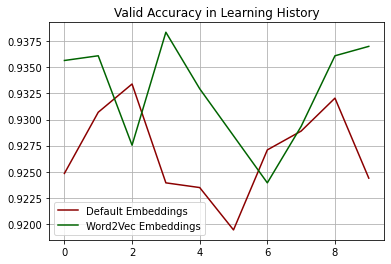

In [42]:
plt.plot(history1.history['val_acc'], label='Default Embeddings', c='darkred')
plt.plot(history2.history['val_acc'], label='Word2Vec Embeddings', c='darkgreen')
plt.title('Valid Accuracy in Learning History')
plt.legend(loc='best')
plt.grid(True)
plt.show()